In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from glob import glob
from pathlib import Path

import numpy as np
from nilearn.image import load_img
from nilearn.maskers import NiftiMasker
from nilearn.masking import intersect_masks

In [2]:
data_dir = Path(
    '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/output_surveyMedley_noderivs_rerun/questionnaire_averages'
)

fmri_prep_dir = '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/fmriprep'

In [3]:
# Get all .nii.gz files in the directory
all_files = list(data_dir.glob('*_questionnaire_avg_sub_*.nii.gz'))

# Group files by subject
subject_files = defaultdict(list)
for file in all_files:
    subject = file.name.split('sub_')[-1].split('.')[0]
    questionnaire = file.name.split('_questionnaire_')[0]
    subject_files[subject].append((questionnaire, file))

# Keep only subjects with all 5 questionnaires
complete_subjects = {
    subject: files for subject, files in subject_files.items() if len(files) == 5
}

# Create a list of cleaned file paths
cleaned_files = [file for files in complete_subjects.values() for _, file in files]

print(len(all_files))
print(len(cleaned_files))

330
330


In [4]:
# Create a dictionary mapping questionnaires to integers
questionnaires = sorted(
    set(q for files in complete_subjects.values() for q, _ in files)
)
questionnaire_dict = {name: i + 1 for i, name in enumerate(questionnaires)}

# Create sub_id and item_id vectors
sub_ids = []
item_ids = []
data_files = []

for subject, files in complete_subjects.items():
    for questionnaire, file in sorted(files):  # Sort to ensure consistent order
        sub_ids.append(int(subject))
        item_ids.append(questionnaire_dict[questionnaire])
        data_files.append(file)

In [5]:
def create_group_mask(sub_ids, fmri_prep_dir):
    masks = []
    for sub_id in sub_ids:
        mask_files = glob(
            f'{fmri_prep_dir}/sub-s{sub_id}/ses*/func/*surveyMedley*mask.nii.gz'
        )
        if not mask_files:
            print(f'Warning: No mask found for subject {sub_id}')
            continue
        if len(mask_files) > 1:
            print(
                f'Warning: Multiple masks found for subject {sub_id}, using the first one'
            )
        mask_path = mask_files[0]
        masks.append(load_img(mask_path))

    if not masks:
        raise ValueError('No masks were found for any subjects')

    # Create a mask that includes voxels present in 100% of subject masks
    group_mask = intersect_masks(masks, threshold=1.0)

    return group_mask

In [6]:
group_mask = create_group_mask(sub_ids, fmri_prep_dir)

In [7]:
mask_data = group_mask.get_fdata()  # Use get_data() for older versions of nibabel

# Count non-zero voxels
in_mask_voxel_count = np.count_nonzero(mask_data)

print(in_mask_voxel_count)

153964


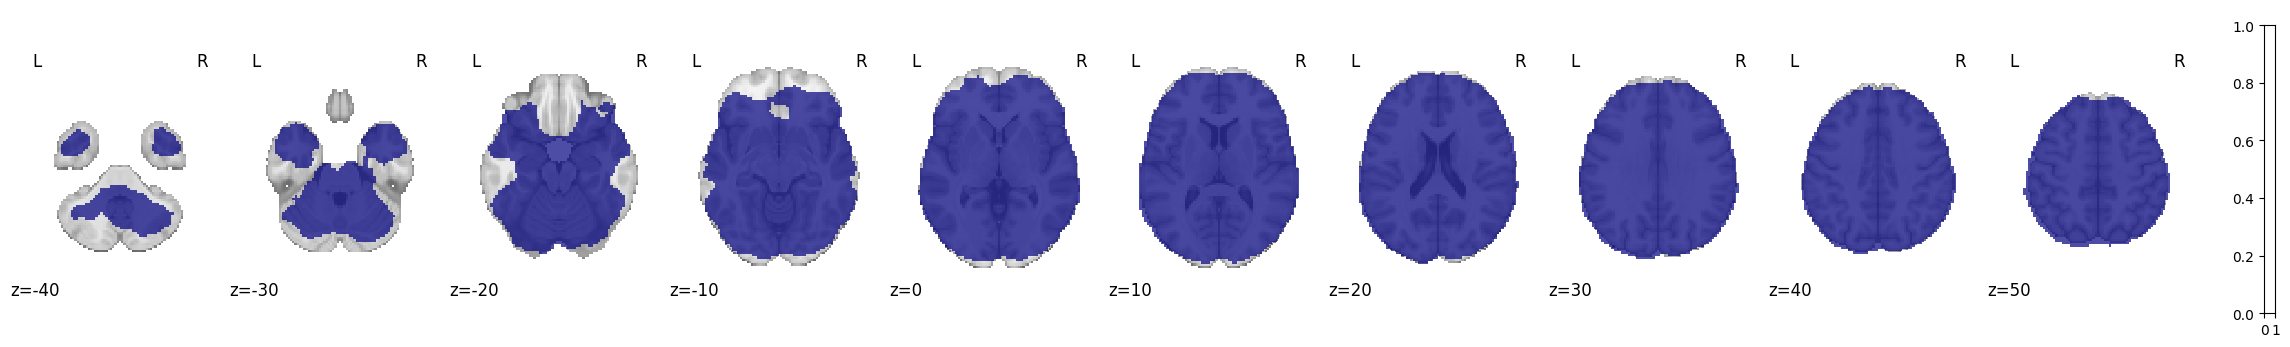

In [8]:
import matplotlib.pyplot as plt
from nilearn import plotting

slice_indices = [-40, -30, -20, -10, 0, 10, 20, 30, 40, 50]
plotting.plot_roi(group_mask, cut_coords=slice_indices, display_mode='z')
plt.show()

In [9]:
import numpy as np

# Create a NiftiMasker using the group_mask
masker = NiftiMasker(
    mask_img=group_mask,  # Use the group_mask you've already created
    standardize=False,  # No standardization
    smoothing_fwhm=None,  # No smoothing
    memory='nilearn_cache',
    memory_level=1,
)

# Fit the masker first
masker.fit()

# Now transform the data
fmri_data = masker.transform(data_files)

# Create the brain_data matrix
brain_data = fmri_data


In [10]:
# Convert sub_id and item_id to numpy arrays
sub_ids = np.array(sub_ids)
item_ids = np.array(item_ids)

# Create a dictionary that pairs the integer (key) with the questionnaire name (value)
questionnaire_name_dict = {v: k for k, v in questionnaire_dict.items()}

print(f'Number of subjects: {len(complete_subjects)}')
print(f'Shape of brain_data: {brain_data.shape}')
print(f'Questionnaire mapping: {questionnaire_name_dict}')

# If you want to check the number of voxels in the mask
n_voxels_in_mask = np.sum(masker.mask_img_.get_fdata() != 0)
print(f'Number of voxels in the mask: {n_voxels_in_mask}')

Number of subjects: 66
Shape of brain_data: (330, 153964)
Questionnaire mapping: {1: 'brief', 2: 'future_time', 3: 'grit', 4: 'impulsive_venture', 5: 'upps'}
Number of voxels in the mask: 153964


In [11]:
from partition_search_analysis_functions import (
    center_within_subject,
    make_brain_maps,
    plot_maps,
    run_partition_analysis,
)

In [ ]:
# Usage example
# brain_masker = your nilearn masker object
# slices = [20, 30, 40]  # example z-slices
# brain_data_centered = center_within_subject(brain_data, sub_id)
# best_map, max_score_map, gap_map, entropy_map, key = run_partition_analysis(brain_data_centered, sub_id, item_id, 5, brain_masker)
# best_img, max_score_img, gap_img, entropy_img = save_maps_as_nifti(best_map, max_score_map, gap_map, entropy_map, brain_masker, "partition_analysis")
# maps = [best_img, max_score_img, gap_img, entropy_img]
# map_titles = ['Best Partition ID', 'Max Partition Score', 'Score Gap', 'Entropy']
# plot_maps(maps, map_titles, slices, "partition_maps.pdf")
# label_mapper = {1:'label1', 2:'label2', 3:'label3', 4:'label4', 5:'label5'}
# plot_partition_grid(key, n_levels=5, label_

In [12]:
brain_data_centered = center_within_subject(brain_data, sub_ids)

In [13]:
np.unique(item_ids)

array([1, 2, 3, 4, 5])

In [14]:
best_map, max_score_map, gap_map, entropy_map, key = run_partition_analysis(
    brain_data_centered, sub_ids, item_ids, 5, masker
)

Cluster: [1], Mask sum: 66
Cluster: [2, 3, 4, 5], Mask sum: 264
Partition [[1], [2, 3, 4, 5]]: Min score = 9.578336900228186e-12, Max score = 14820.119106855986
Cluster: [1, 2], Mask sum: 132
Cluster: [3, 4, 5], Mask sum: 198
Partition [[1, 2], [3, 4, 5]]: Min score = 7.279060124385102e-12, Max score = 2354.6436234642697
Cluster: [2], Mask sum: 66
Cluster: [1, 3, 4, 5], Mask sum: 264
Partition [[2], [1, 3, 4, 5]]: Min score = 4.0992040607647725e-11, Max score = 1756.495097360867
Cluster: [1], Mask sum: 66
Cluster: [2], Mask sum: 66
Cluster: [3, 4, 5], Mask sum: 198
Partition [[1], [2], [3, 4, 5]]: Min score = 1.402453626047225e-05, Max score = 158152.84001388634
Cluster: [1, 2, 3], Mask sum: 198
Cluster: [4, 5], Mask sum: 132
Partition [[1, 2, 3], [4, 5]]: Min score = 1.053380608230521e-10, Max score = 122649.53386911107
Cluster: [2, 3], Mask sum: 132
Cluster: [1, 4, 5], Mask sum: 198
Partition [[2, 3], [1, 4, 5]]: Min score = 7.429767427404475e-12, Max score = 2884.4232563385335
Clust

In [15]:
best_map

array([50, 46, 50, ..., 49, 48, 47])

In [28]:
key

{1: [[1], [2, 3, 4, 5]],
 2: [[1, 2], [3, 4, 5]],
 3: [[2], [1, 3, 4, 5]],
 4: [[1], [2], [3, 4, 5]],
 5: [[1, 2, 3], [4, 5]],
 6: [[2, 3], [1, 4, 5]],
 7: [[1], [2, 3], [4, 5]],
 8: [[1, 3], [2, 4, 5]],
 9: [[3], [1, 2, 4, 5]],
 10: [[1], [3], [2, 4, 5]],
 11: [[1, 2], [3], [4, 5]],
 12: [[2], [1, 3], [4, 5]],
 13: [[2], [3], [1, 4, 5]],
 14: [[1], [2], [3], [4, 5]],
 15: [[1, 2, 3, 4], [5]],
 16: [[2, 3, 4], [1, 5]],
 17: [[1], [2, 3, 4], [5]],
 18: [[1, 3, 4], [2, 5]],
 19: [[3, 4], [1, 2, 5]],
 20: [[1], [3, 4], [2, 5]],
 21: [[1, 2], [3, 4], [5]],
 22: [[2], [1, 3, 4], [5]],
 23: [[2], [3, 4], [1, 5]],
 24: [[1], [2], [3, 4], [5]],
 25: [[1, 2, 4], [3, 5]],
 26: [[2, 4], [1, 3, 5]],
 27: [[1], [2, 4], [3, 5]],
 28: [[1, 4], [2, 3, 5]],
 29: [[4], [1, 2, 3, 5]],
 30: [[1], [4], [2, 3, 5]],
 31: [[1, 2], [4], [3, 5]],
 32: [[2], [1, 4], [3, 5]],
 33: [[2], [4], [1, 3, 5]],
 34: [[1], [2], [4], [3, 5]],
 35: [[1, 2, 3], [4], [5]],
 36: [[2, 3], [1, 4], [5]],
 37: [[2, 3], [4], [1, 5]

In [16]:
unique_values, counts = np.unique(best_map, return_counts=True)
partition_counts = {
    str(value): int(count) for value, count in zip(unique_values, counts)
}

partition_counts

{'2': 140,
 '5': 930,
 '6': 242,
 '7': 1664,
 '8': 79,
 '11': 1761,
 '12': 1129,
 '14': 9208,
 '16': 252,
 '18': 118,
 '19': 277,
 '20': 544,
 '21': 1795,
 '23': 648,
 '24': 10364,
 '25': 190,
 '26': 91,
 '27': 440,
 '28': 124,
 '31': 1350,
 '32': 466,
 '34': 7137,
 '36': 1750,
 '37': 1513,
 '38': 23969,
 '39': 1102,
 '41': 637,
 '42': 11252,
 '43': 1006,
 '44': 550,
 '46': 9233,
 '47': 25207,
 '48': 17100,
 '49': 11223,
 '50': 10473}

In [ ]:
max_score_map

In [17]:
best_img, max_score_img, gap_img, entropy_img = make_brain_maps(
    best_map,
    max_score_map,
    gap_map,
    entropy_map,
    masker,
)

In [18]:
out_prefix = 'maps/q_means'
best_img.to_filename(f'{out_prefix}_best_partition.nii.gz')
max_score_img.to_filename(f'{out_prefix}_max_score.nii.gz')
gap_img.to_filename(f'{out_prefix}_score_gap.nii.gz')
entropy_img.to_filename(f'{out_prefix}_entropy.nii.gz')

/home/users/jmumford/jaemon/partition_search_analysis_functions.py:326: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


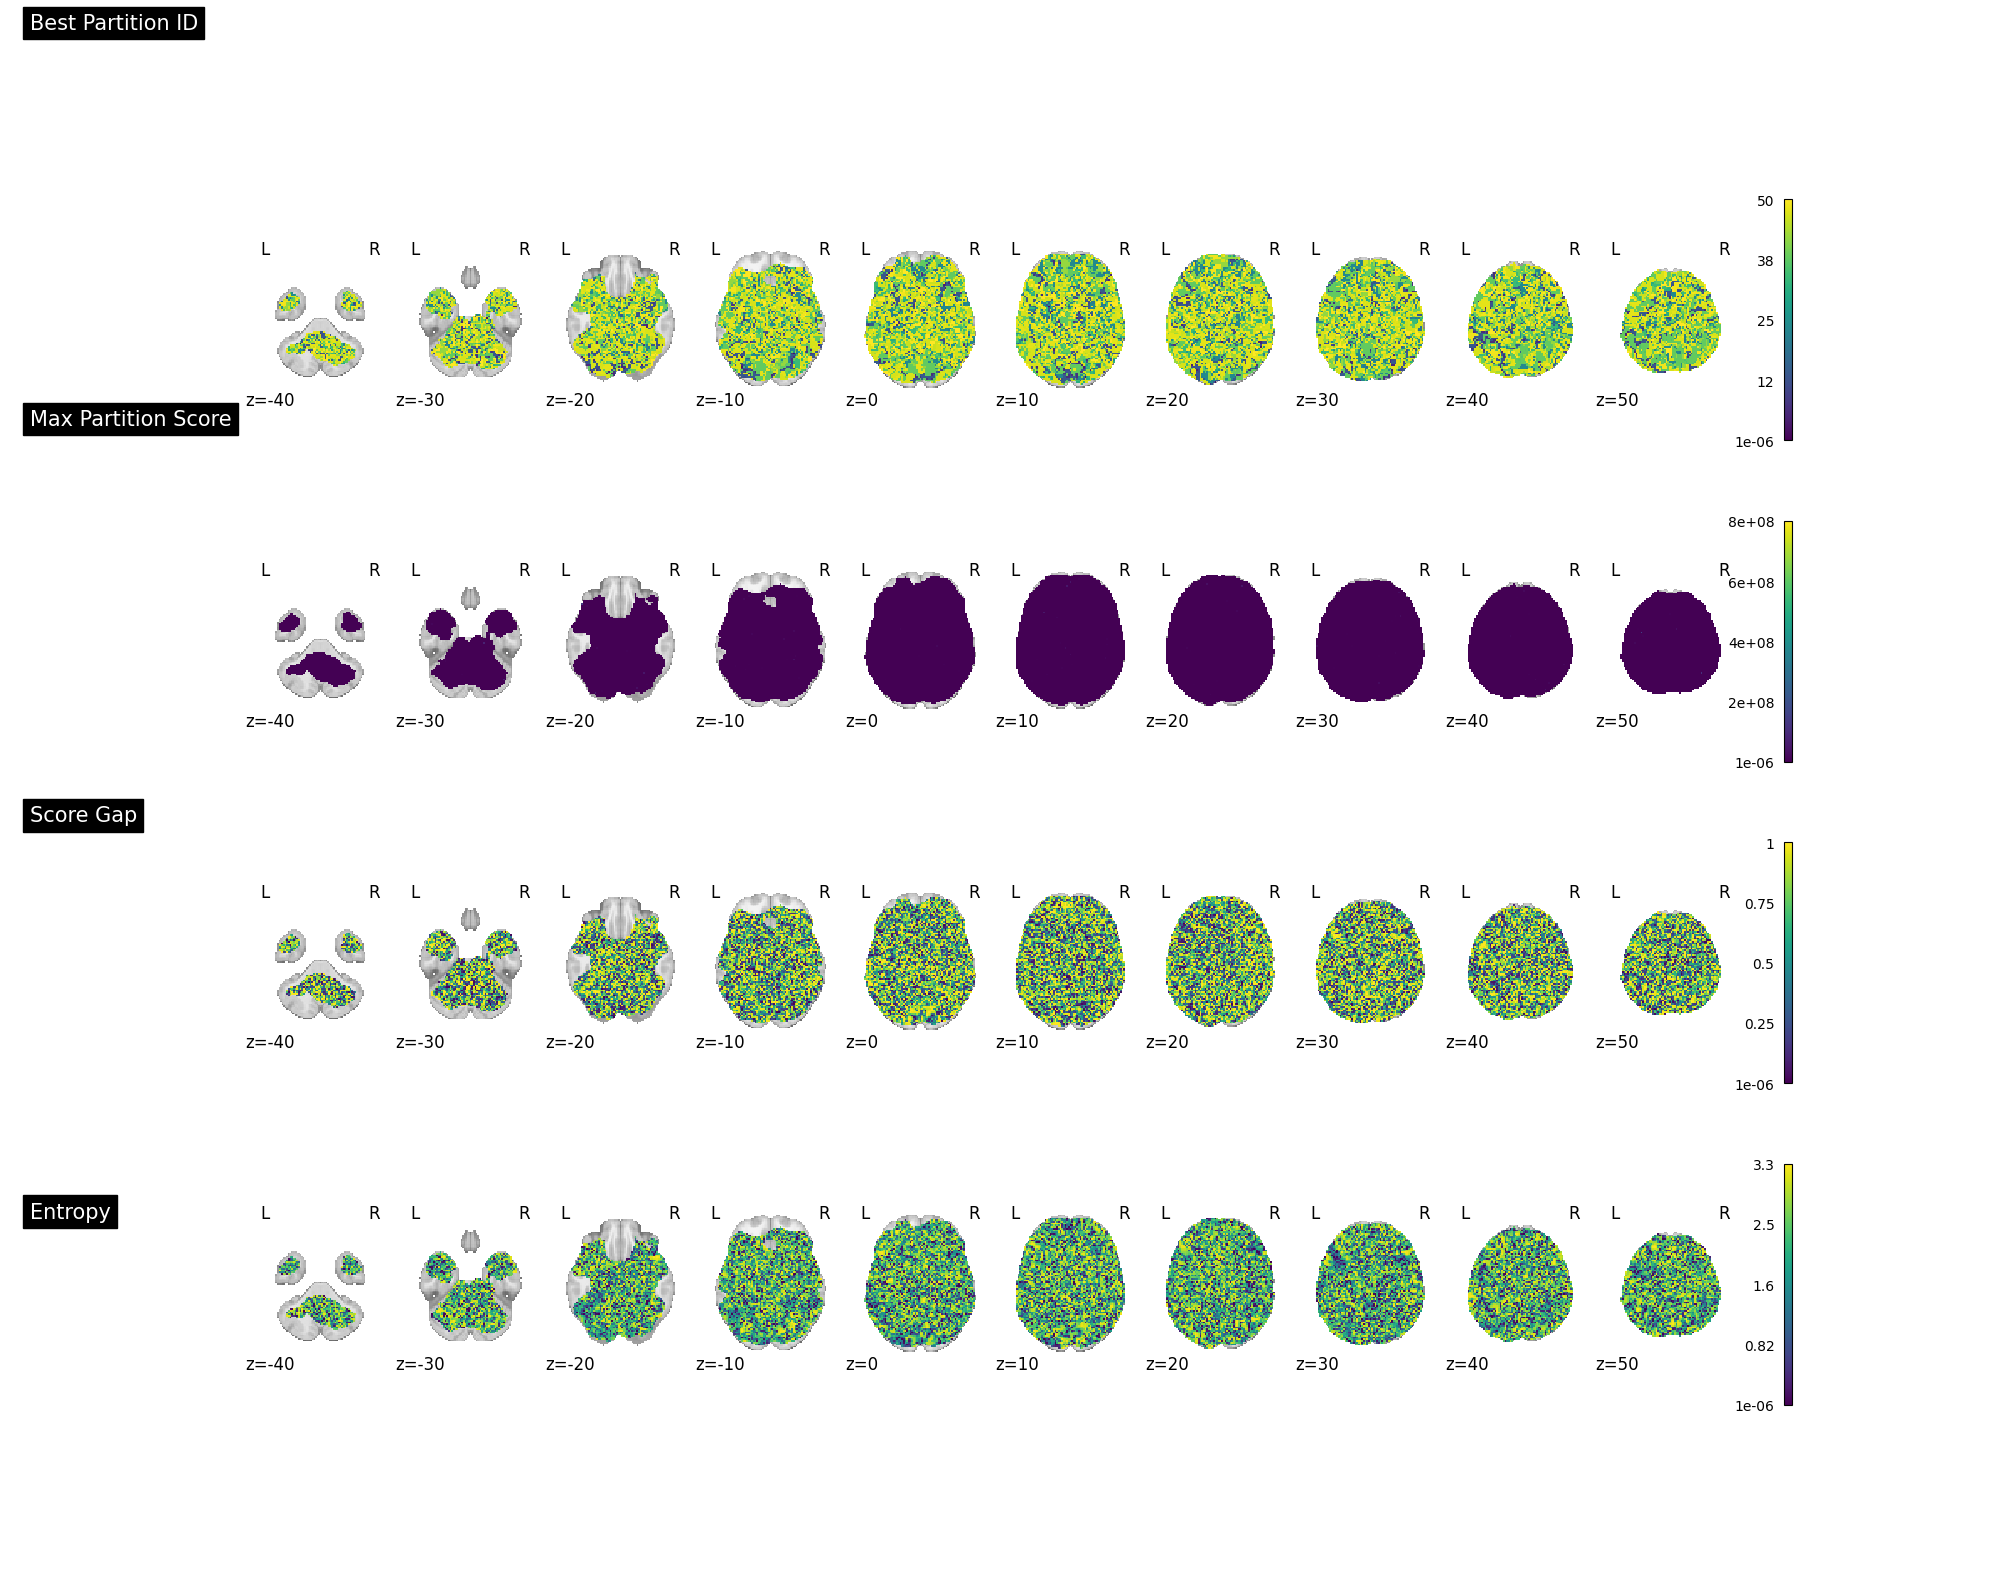

In [19]:
maps = [best_img, max_score_img, gap_img, entropy_img]
map_titles = ['Best Partition ID', 'Max Partition Score', 'Score Gap', 'Entropy']
plot_maps(
    maps,
    map_titles,
    slice_indices,
    'junk.pdf',
    savefig=False,
)

## Trying searchlight

In [75]:
from partition_search_analysis_functions import (
    get_voxel_coordinates,
    searchlight_partition_analysis,
    all_partitions,
    plot_partition_grid,
)

masker = NiftiMasker(
    mask_img=group_mask,
    standardize=False,
    smoothing_fwhm=None,
    memory='nilearn_cache',
    memory_level=1,
)
masker.fit()

fmri_data = masker.transform(data_files)
brain_data = fmri_data
brain_data_centered = center_within_subject(brain_data, sub_ids)

In [63]:
all_partitions(5)

[[[1], [2, 3, 4, 5]],
 [[1, 2], [3, 4, 5]],
 [[2], [1, 3, 4, 5]],
 [[1], [2], [3, 4, 5]],
 [[1, 2, 3], [4, 5]],
 [[2, 3], [1, 4, 5]],
 [[1], [2, 3], [4, 5]],
 [[1, 3], [2, 4, 5]],
 [[3], [1, 2, 4, 5]],
 [[1], [3], [2, 4, 5]],
 [[1, 2], [3], [4, 5]],
 [[2], [1, 3], [4, 5]],
 [[2], [3], [1, 4, 5]],
 [[1], [2], [3], [4, 5]],
 [[1, 2, 3, 4], [5]],
 [[2, 3, 4], [1, 5]],
 [[1], [2, 3, 4], [5]],
 [[1, 3, 4], [2, 5]],
 [[3, 4], [1, 2, 5]],
 [[1], [3, 4], [2, 5]],
 [[1, 2], [3, 4], [5]],
 [[2], [1, 3, 4], [5]],
 [[2], [3, 4], [1, 5]],
 [[1], [2], [3, 4], [5]],
 [[1, 2, 4], [3, 5]],
 [[2, 4], [1, 3, 5]],
 [[1], [2, 4], [3, 5]],
 [[1, 4], [2, 3, 5]],
 [[4], [1, 2, 3, 5]],
 [[1], [4], [2, 3, 5]],
 [[1, 2], [4], [3, 5]],
 [[2], [1, 4], [3, 5]],
 [[2], [4], [1, 3, 5]],
 [[1], [2], [4], [3, 5]],
 [[1, 2, 3], [4], [5]],
 [[2, 3], [1, 4], [5]],
 [[2, 3], [4], [1, 5]],
 [[1], [2, 3], [4], [5]],
 [[1, 3], [2, 4], [5]],
 [[3], [1, 2, 4], [5]],
 [[3], [2, 4], [1, 5]],
 [[1], [3], [2, 4], [5]],
 [[1, 3], [4

In [34]:
print(f'Brain data shape: {brain_data.shape}')
print(f'Unique sub_id values: {np.unique(sub_ids)}')
print(f'Unique item_id values: {np.unique(item_ids)}')

Brain data shape: (330, 153964)
Unique sub_id values: [130 172 192 234 465 518 519 524 526 546 548 549 553 554 555 557 558 561
 567 570 572 574 577 582 583 584 585 586 587 589 590 591 592 593 594 595
 596 601 602 604 606 607 608 609 611 612 613 614 616 619 621 622 626 628
 629 633 636 637 638 641 642 643 645 646 647 648]
Unique item_id values: [1 2 3 4 5]


In [54]:
brain_data_centered.shape

(330, 153964)

In [70]:
# Get voxel coordinates
voxel_coords = get_voxel_coordinates(group_mask)

# Run searchlight analysis
(
    best_partition_map,
    max_partition_score_map,
    score_gap_map,
    entropy_map,
    partition_key,
) = searchlight_partition_analysis(
    brain_data_centered, voxel_coords, sub_ids, item_ids, radius=7, n_voxels=1000
)


Number of subjects: 66
Number of items: 5
Shape of brain_data: (330, 153964)
Number of partitions: 50
First few partitions:
  1: [[1], [2, 3, 4, 5]]
  2: [[1, 2], [3, 4, 5]]
  3: [[2], [1, 3, 4, 5]]
  4: [[1], [2], [3, 4, 5]]
  5: [[1, 2, 3], [4, 5]]
Processed 1000 out of 1000 voxels. Elapsed time: 96.65 seconds
Finished processing 1000 voxels. Total time: 96.79 seconds


In [78]:
plot_partition_grid(
    partition_key, 5, label_mapper=None, out_file='maps/searchlight_partition_grid.pdf'
)

In [59]:
153 * 103 / 60

262.65

In [71]:
np.unique(best_partition_map, return_counts=True)

(array([ 5,  6, 15, 16, 19, 29]), array([131,  34, 152,  12,  23, 648]))

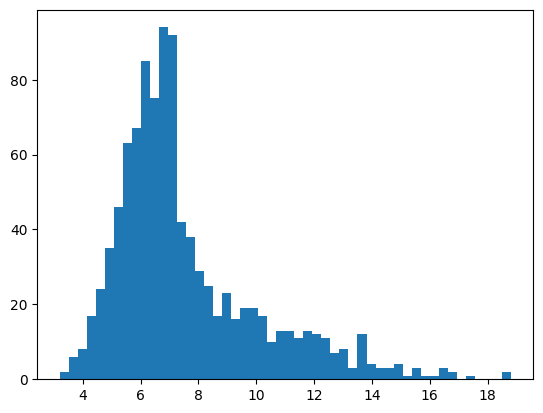

In [72]:
plt.hist(max_partition_score_map, 50)
plt.show()

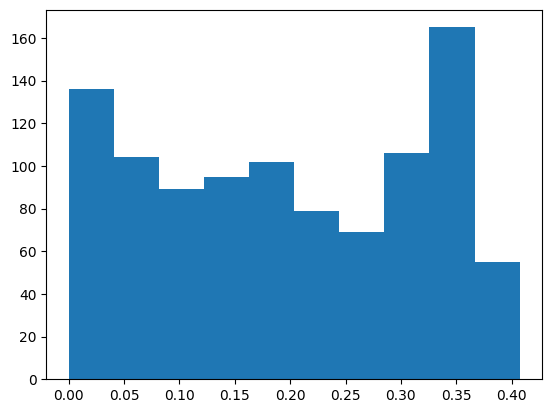

In [73]:
plt.hist(score_gap_map)
plt.show()

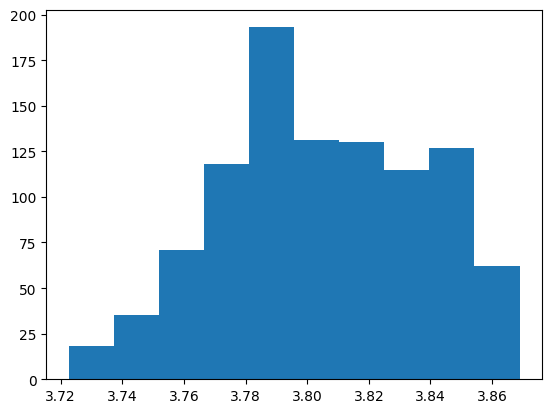

In [74]:
plt.hist(entropy_map)
plt.show()

In [38]:
partition_key

{1: [[1], [2, 3, 4, 5]],
 2: [[1, 2], [3, 4, 5]],
 3: [[2], [1, 3, 4, 5]],
 4: [[1], [2], [3, 4, 5]],
 5: [[1, 2, 3], [4, 5]],
 6: [[2, 3], [1, 4, 5]],
 7: [[1], [2, 3], [4, 5]],
 8: [[1, 3], [2, 4, 5]],
 9: [[3], [1, 2, 4, 5]],
 10: [[1], [3], [2, 4, 5]],
 11: [[1, 2], [3], [4, 5]],
 12: [[2], [1, 3], [4, 5]],
 13: [[2], [3], [1, 4, 5]],
 14: [[1], [2], [3], [4, 5]],
 15: [[1, 2, 3, 4], [5]],
 16: [[2, 3, 4], [1, 5]],
 17: [[1], [2, 3, 4], [5]],
 18: [[1, 3, 4], [2, 5]],
 19: [[3, 4], [1, 2, 5]],
 20: [[1], [3, 4], [2, 5]],
 21: [[1, 2], [3, 4], [5]],
 22: [[2], [1, 3, 4], [5]],
 23: [[2], [3, 4], [1, 5]],
 24: [[1], [2], [3, 4], [5]],
 25: [[1, 2, 4], [3, 5]],
 26: [[2, 4], [1, 3, 5]],
 27: [[1], [2, 4], [3, 5]],
 28: [[1, 4], [2, 3, 5]],
 29: [[4], [1, 2, 3, 5]],
 30: [[1], [4], [2, 3, 5]],
 31: [[1, 2], [4], [3, 5]],
 32: [[2], [1, 4], [3, 5]],
 33: [[2], [4], [1, 3, 5]],
 34: [[1], [2], [4], [3, 5]],
 35: [[1, 2, 3], [4], [5]],
 36: [[2, 3], [1, 4], [5]],
 37: [[2, 3], [4], [1, 5]

In [27]:
np.unique(best_partition_map)

array([15])

In [32]:
max_partition_score_map.shape

(5000,)

In [24]:
best_img, max_score_img, gap_img, entropy_img = make_brain_maps(
    best_partition_map,
    max_partition_score_map,
    score_gap_map,
    entropy_map,
    masker,
)

ValueError: Error in inverse transform: Input to 'inverse_transform' has wrong shape.
Expected (153964,).
Got (5000,).

In [ ]:
maps = [best_img, max_score_img, gap_img, entropy_img]
map_titles = ['Best Partition ID', 'Max Partition Score', 'Score Gap', 'Entropy']
plot_maps(
    maps,
    map_titles,
    slice_indices,
    'junk.pdf',
    savefig=False,
)